In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import numpy as np
import pandas as pd

import glob

In [2]:
from fantasy_agn.tools import read_sdss, read_text, read_gama_fits

# Below command import the necessary commands, which will be described later
from fantasy_agn.models import create_input_folder

from fantasy_agn.models import create_feii_model, create_model, create_tied_model, continuum, create_line, create_fixed_model

In [3]:
s=read_sdss('spec-7238-56660-0092.fits')

In [4]:
s.DeRedden()

In [5]:

s.CorRed()

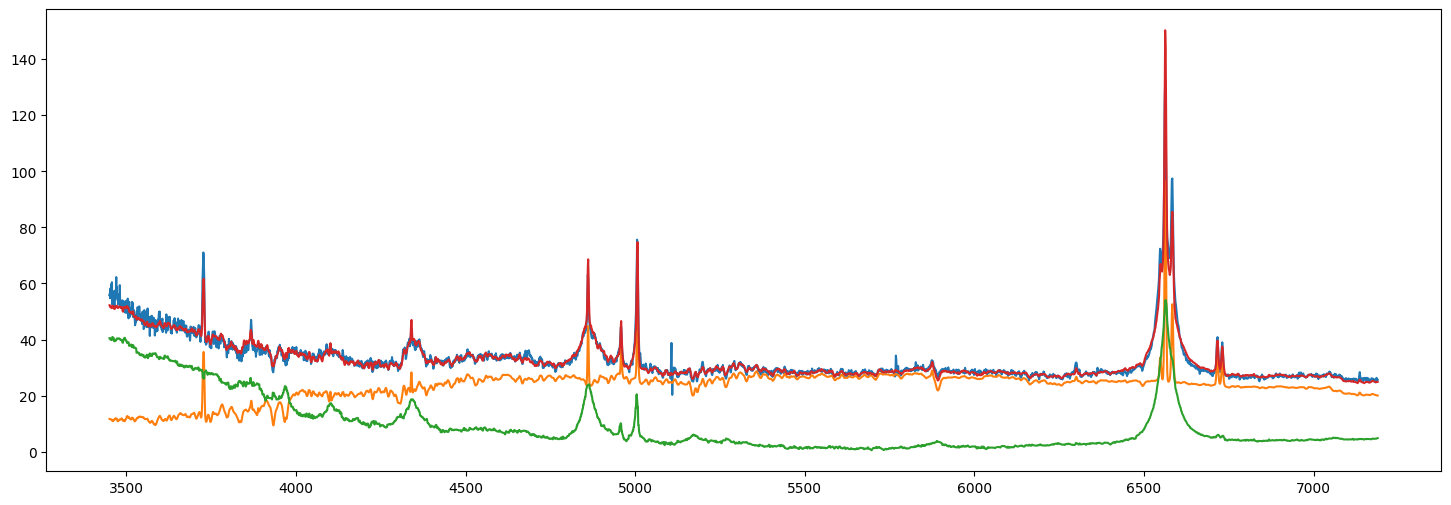

In [6]:
s.fit_host_sdss()

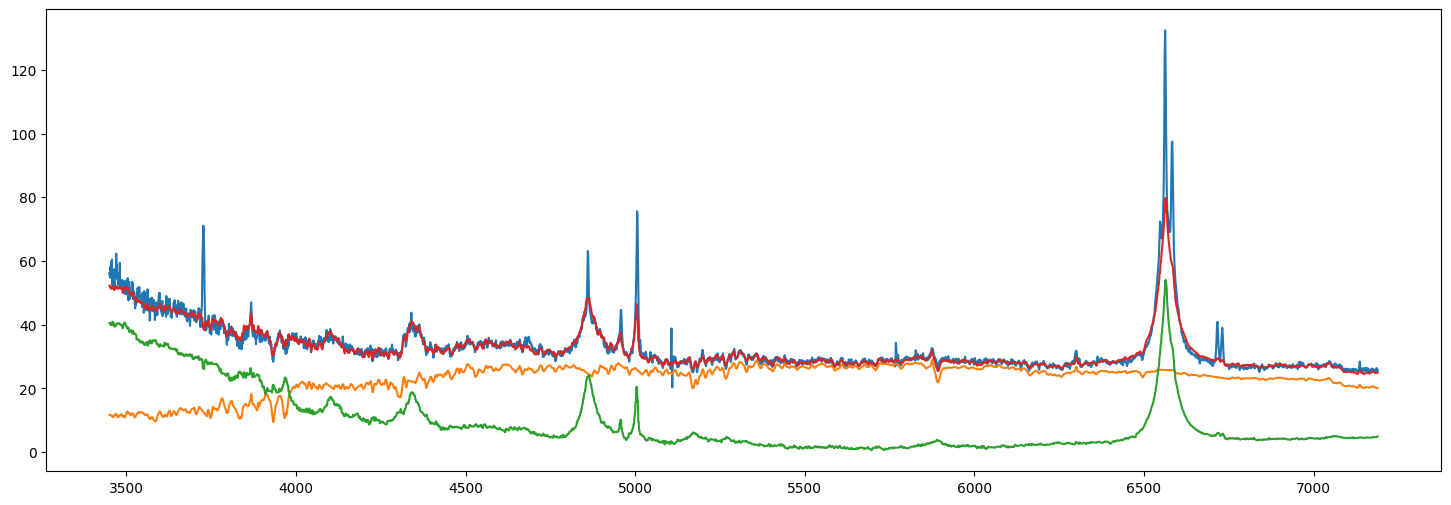

In [7]:
s.restore() #command to restore the spectrum before host galaxy fitting and substraction
s.fit_host_sdss(mask_host=True, custom=False)

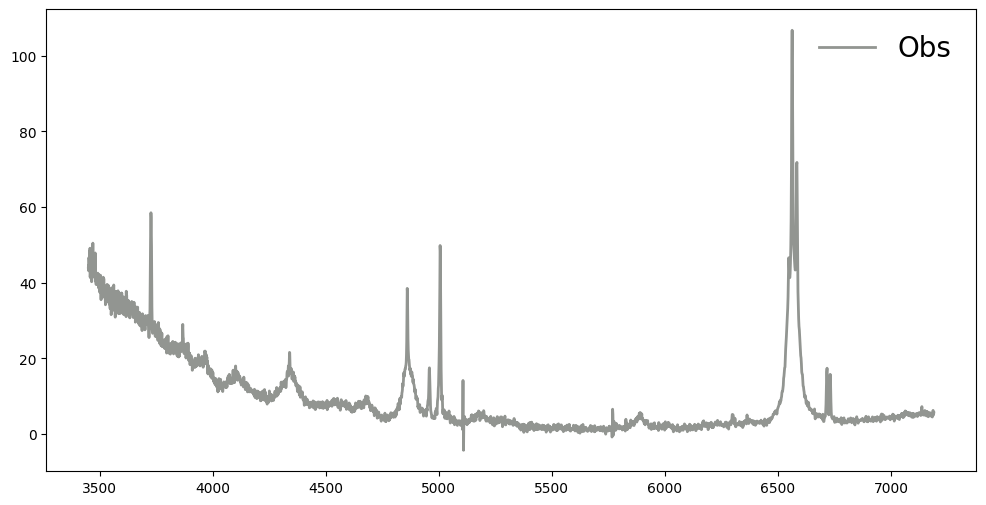

In [8]:
#Let's plot the spectrum for visual inspection.

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)

# It is obvious, e.g. based on the strong blue continuum and absence of absorption line, that the stellar contribution
# from the host galaxy can be negligible.

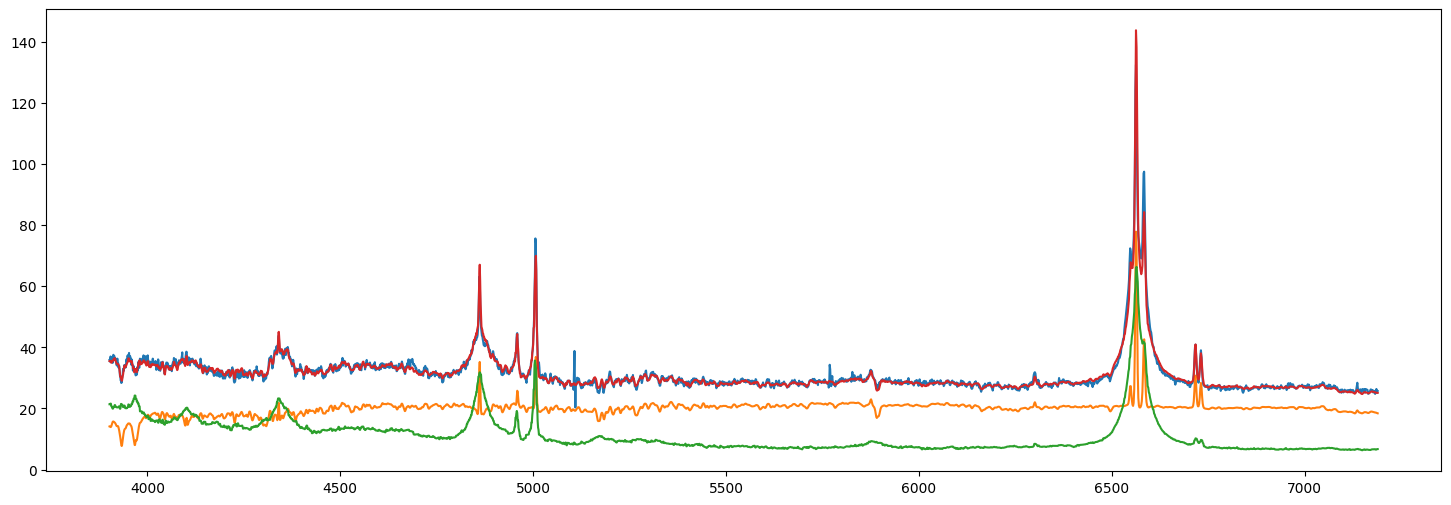

In [9]:
g=read_sdss('spec-7238-56660-0092.fits')
g.DeRedden()
g.CorRed()
g.crop(3900,8000)
g.fit_host_sdss()

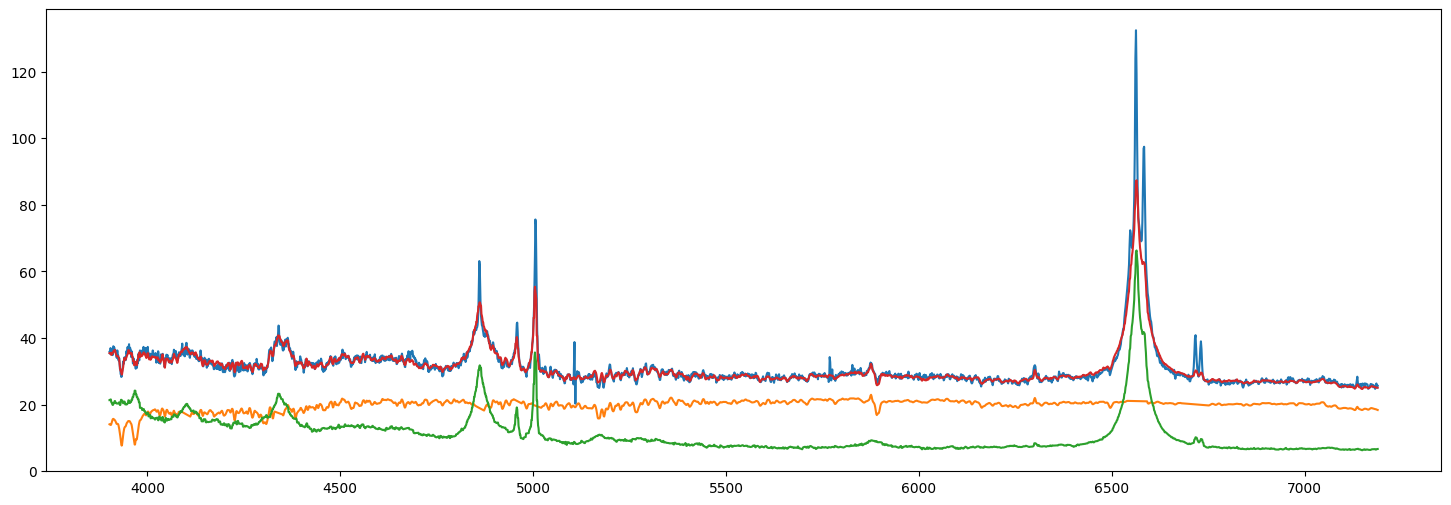

In [10]:
# Let us save the above host, and try fitting with the masked emission lines.
g.host_no_mask=g.host
g.restore()
g.fit_host_sdss(mask_host=True, custom=False)

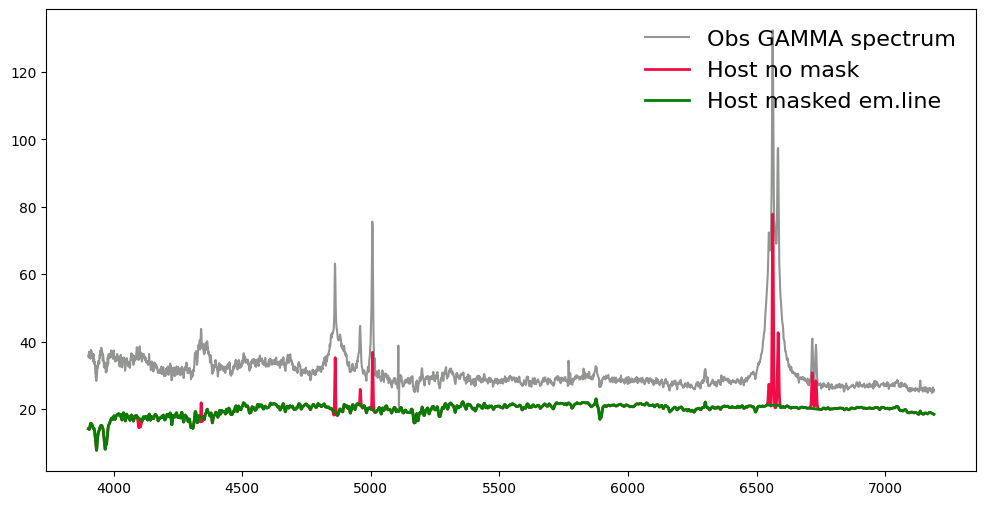

In [11]:
#Let's compare two host-fitting results.

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(12,6))
plt.plot(g.wave, g.flux+g.host, color="#929591", label='Obs GAMMA spectrum' , lw=1.5)
plt.plot(g.wave, g.host_no_mask, color="#F10C45", label='Host no mask', lw=2)
plt.plot(g.wave, g.host, color="green", label='Host masked em.line', lw=2)
plt.legend(loc='upper right',  prop={'size': 16}, frameon=False)


In [12]:
create_input_folder(xmin=4000,xmax=8000, path_to_folder='FANTASYliness/')

Directory  FANTASYliness/  already exists


In [13]:
# Crop function cuts the spectrum in a set wavelength range, e.g., if you want to fit just
# one emission line or a certain wavelength range

s.crop(4000, 8000)
print(s.wave) # simple examine of the wavelength range

[4000.02   4000.942  4001.8623 ... 7185.627  7187.2837 7188.9375]


In [14]:
cont=continuum(s,min_refer=5690, refer=5700, max_refer=5710)
broad=create_fixed_model(['hydrogen.csv'], name='br')
he=create_fixed_model(['helium.csv'], name='he',fwhm=3000, min_fwhm=1000, max_fwhm=5000)
narrow=create_tied_model(name='OIII5007',files=['narrow_basic.csv','hydrogen.csv'],prefix='nr', fwhm=300,min_offset=0, max_offset=300, min_fwhm=200, max_fwhm=400,fix_oiii_ratio=True, position=5006.803341, included=True,min_amplitude=0.2)
fe=create_feii_model(name='feii', fwhm=1800, min_fwhm=1000, max_fwhm=2000, offset=0, min_offset=-3000, max_offset=3000)
#fe.amp_b4p.min=10 #An example how to force the amplitude of a selected FeII multiplet.

In [15]:
model = cont+broad+narrow+he+fe

In [16]:
s.fit(model, ntrial=5)

iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5


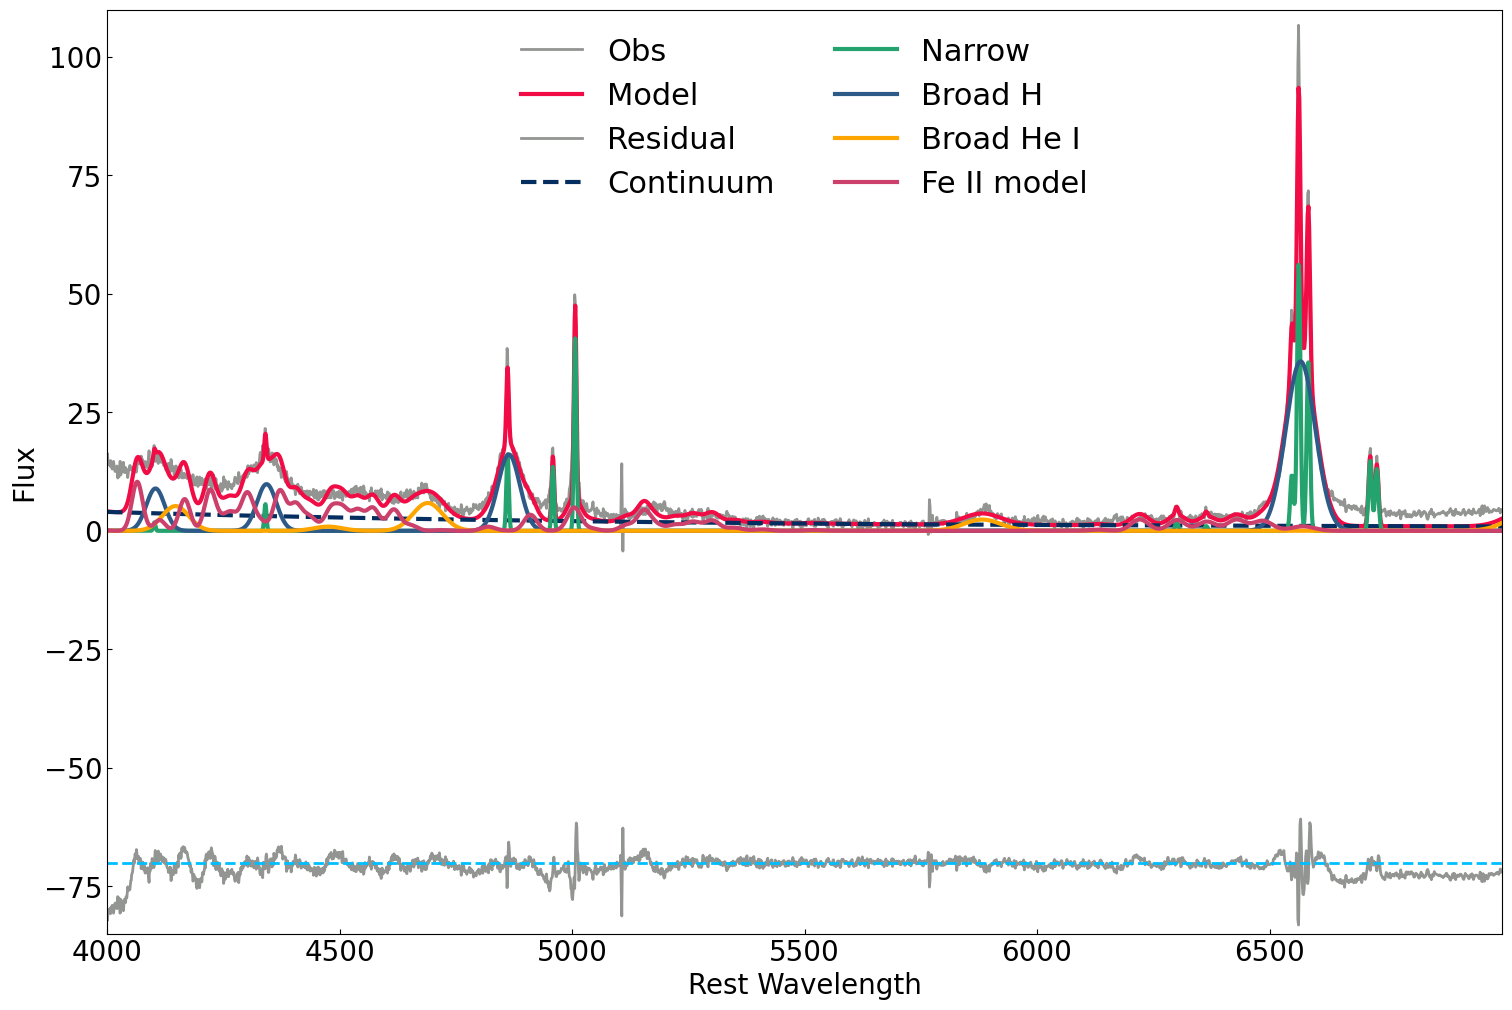

In [17]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,12))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.plot(s.wave, model(s.wave), color="#F10C45",label='Model',lw=3)
plt.plot(s.wave, model(s.wave)-s.flux-70, '-',color="#929591", label='Residual', lw=2)
plt.axhline(y=-70, color='deepskyblue', linestyle='--', lw=2)

plt.plot(s.wave, cont(s.wave),'--',color="#042E60",label='Continuum', lw=3)
plt.plot(s.wave, narrow(s.wave),label='Narrow',color="#25A36F",lw=3)
plt.plot(s.wave, broad(s.wave), label='Broad H', lw=3, color="#2E5A88")
plt.plot(s.wave, he(s.wave), label='Broad He I', lw=3, color="orange")
plt.plot(s.wave, fe(s.wave),'-',color="#CB416B",label='Fe II model', lw=3)

plt.xlabel('Rest Wavelength',fontsize=20)
plt.ylabel('Flux',fontsize=20)
plt.xlim(4000,7000)
plt.ylim(-85,110)
plt.tick_params(which='both', direction="in")
plt.yticks(fontsize=20)
plt.xticks(np.arange(4000, 7000, step=500),fontsize=20)
plt.legend(loc='upper center',  prop={'size': 22}, frameon=False, ncol=2)

plt.savefig('my_plot.jpg', format='jpg', dpi=300)

In [18]:
# Integrate total FeII model,
flux_feII=np.sum(fe(s.wave))
print("FeII total flux=",flux_feII)

# Mask the wavelength range of interess (e.g. Ha line) and integrate broad component.
x=s.wave
mask_ha=(x>6300)&(x<6700)
Ha_broad=np.sum(broad(s.wave)[mask_ha])
print("Ha_broad=",Ha_broad)


FeII total flux= 3814.5115
Ha_broad= 1873.3634
